In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision import datasets, transforms

from collections import Counter

import cv2
from PIL import Image

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Exploratory Data Analysis (EDA)

Uploading Data

In [29]:
from google.colab import files
import zipfile

uploaded = files.upload()

for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')
    print(f"Extracted: {filename}")

Saving Test_250.zip to Test_250.zip
Saving Train_1000.zip to Train_1000.zip
Extracted: Test_250.zip
Extracted: Train_1000.zip


### 1) Dataset Structure Analysis

In [30]:
def analyze_dataset_structure(data_dir='train'):
    emotions = os.listdir(data_dir)
    emotions = [e for e in emotions if os.path.isdir(os.path.join(data_dir, e))]

    stats_data = []
    total_images = 0

    for emotion in emotions:
        emotion_path = os.path.join(data_dir, emotion)
        image_files = [f for f in os.listdir(emotion_path)
                      if f.lower().endswith(('.jpg'))]
        count = len(image_files)
        total_images += count
        stats_data.append({'Emotion': emotion, 'Count': count})

    df_stats = pd.DataFrame(stats_data)
    df_stats['Percentage'] = (df_stats['Count'] / total_images * 100).round(2)
    df_stats = df_stats.sort_values('Count', ascending=False)

    print(f"\nTotal Images: {total_images}")
    print(f"Number of Classes: {len(emotions)}\n")
    print(df_stats.to_string(index=False))

    # Calculating class imbalance ratio
    max_count = df_stats['Count'].max()
    min_count = df_stats['Count'].min()
    imbalance_ratio = max_count / min_count
    print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")

    return df_stats

df_stats = analyze_dataset_structure('train')


Total Images: 4000
Number of Classes: 4

Emotion  Count  Percentage
  happy   1000        25.0
neutral   1000        25.0
  angry   1000        25.0
    sad   1000        25.0

Class Imbalance Ratio: 1.00:1


### 2) Class Distribution Visualization

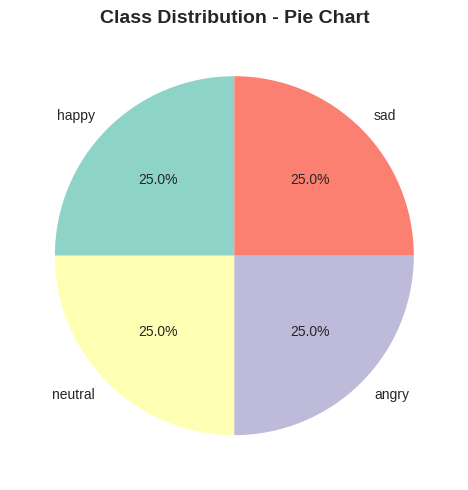

In [31]:
def visualize_class_distribution(df_stats):
    fig, axes = plt.subplots(1, 1, figsize=(18, 5))

    colors = plt.cm.Set3(range(len(df_stats)))
    axes.pie(df_stats['Count'], labels=df_stats['Emotion'], autopct='%1.1f%%',
                colors=colors, startangle=90)
    axes.set_title('Class Distribution - Pie Chart', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

visualize_class_distribution(df_stats)

### 3) Image Property Visualizations

In [32]:
import PIL.Image as PIL_Image_Module

def analyze_image_properties(data_dir='train', sample_size=100):
  emotions = [e for e in os.listdir(data_dir)
                if os.path.isdir(os.path.join(data_dir, e))]

  properties = {
        'emotion': [],
        'width': [],
        'height': [],
        'brightness': [],
        'contrast': [],
        'aspect_ratio': []
    }

  for emotion in emotions:
        emotion_path = os.path.join(data_dir, emotion)
        image_files = os.listdir(emotion_path)[:sample_size]

        for img_file in image_files:
            img_path = os.path.join(emotion_path, img_file)
            img = PIL_Image_Module.open(img_path).convert('L')
            img_array = np.array(img)

            properties['emotion'].append(emotion)
            properties['width'].append(img.width)
            properties['height'].append(img.height)
            properties['brightness'].append(img_array.mean())
            properties['contrast'].append(img_array.std())
            properties['aspect_ratio'].append(img.width / img.height)
  df_props = pd.DataFrame(properties)
  return df_props
df_props = analyze_image_properties('train', sample_size=100)

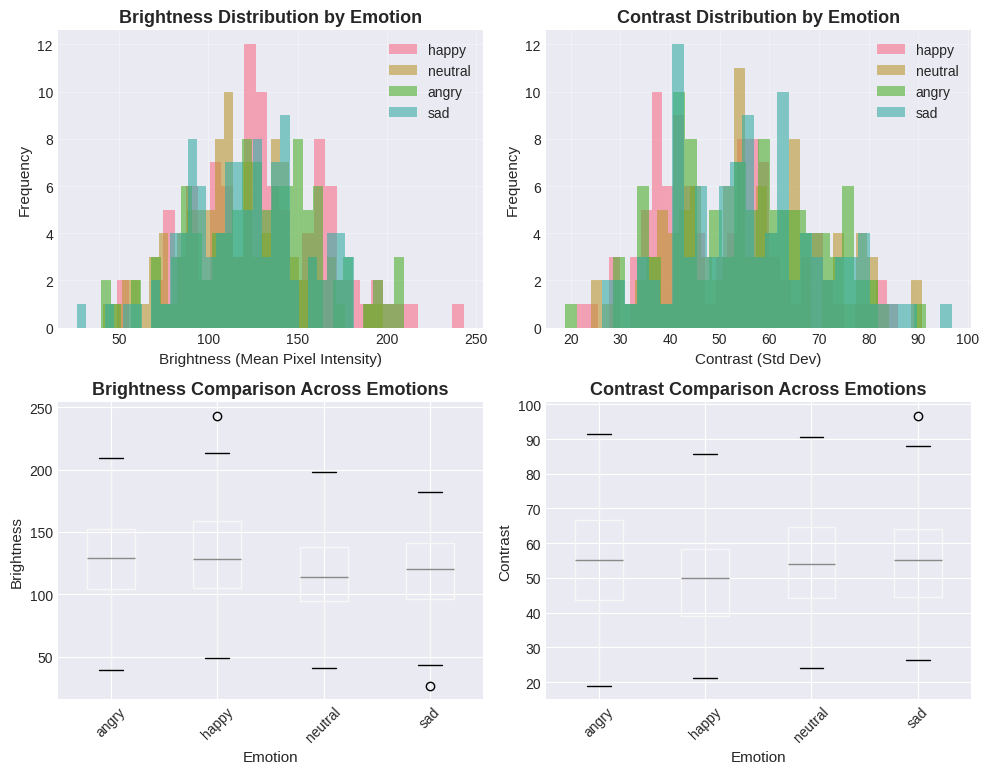

In [33]:
def visualize_image_properties(df_props):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Brightness distribution
    for emotion in df_props['emotion'].unique():
        subset = df_props[df_props['emotion'] == emotion]['brightness']
        axes[0, 0].hist(subset, alpha=0.6, label=emotion, bins=30)
    axes[0, 0].set_xlabel('Brightness (Mean Pixel Intensity)', fontsize=11)
    axes[0, 0].set_ylabel('Frequency', fontsize=11)
    axes[0, 0].set_title('Brightness Distribution by Emotion', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Contrast distribution
    for emotion in df_props['emotion'].unique():
        subset = df_props[df_props['emotion'] == emotion]['contrast']
        axes[0, 1].hist(subset, alpha=0.6, label=emotion, bins=30)
    axes[0, 1].set_xlabel('Contrast (Std Dev)', fontsize=11)
    axes[0, 1].set_ylabel('Frequency', fontsize=11)
    axes[0, 1].set_title('Contrast Distribution by Emotion', fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Box plot for Brightness by emotion
    df_props.boxplot(column='brightness', by='emotion', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Emotion', fontsize=11)
    axes[1, 0].set_ylabel('Brightness', fontsize=11)
    axes[1, 0].set_title('Brightness Comparison Across Emotions', fontsize=13, fontweight='bold')
    plt.sca(axes[1, 0])
    plt.xticks(rotation=45)

    # Box plot for Contrast by emotion
    df_props.boxplot(column='contrast', by='emotion', ax=axes[1, 1])
    axes[1, 1].set_xlabel('Emotion', fontsize=11)
    axes[1, 1].set_ylabel('Contrast', fontsize=11)
    axes[1, 1].set_title('Contrast Comparison Across Emotions', fontsize=13, fontweight='bold')
    plt.sca(axes[1, 1])
    plt.xticks(rotation=45)

    plt.suptitle('')
    plt.tight_layout()
    plt.show()

# Visualize
visualize_image_properties(df_props)

### 4) Sample Images Visualization

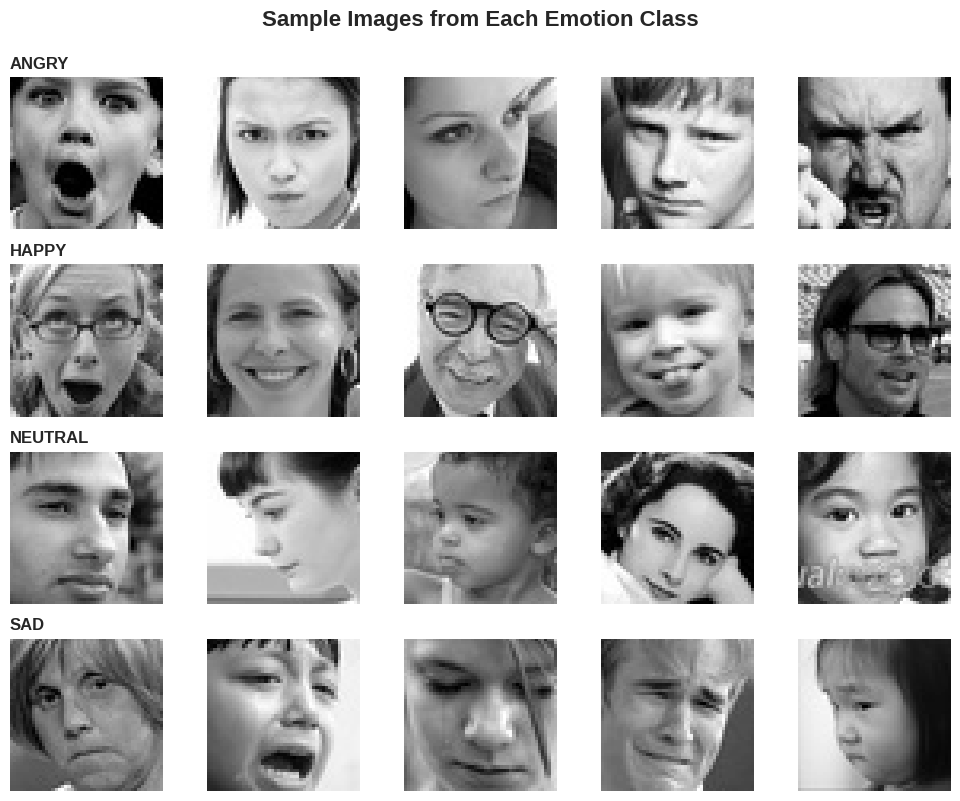

In [34]:
def visualize_sample_images(data_dir='train', n_samples=5):
    emotions = [e for e in os.listdir(data_dir)
                if os.path.isdir(os.path.join(data_dir, e))]
    emotions = sorted(emotions)

    fig, axes = plt.subplots(len(emotions), n_samples, figsize=(10, 2*len(emotions)))

    for i, emotion in enumerate(emotions):
        emotion_path = os.path.join(data_dir, emotion)
        image_files = os.listdir(emotion_path)[:n_samples]

        for j, img_file in enumerate(image_files):
            img_path = os.path.join(emotion_path, img_file)
            img = PIL_Image_Module.open(img_path).convert('L')

            ax = axes[i, j] if len(emotions) > 1 else axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')

            if j == 0:
                ax.set_title(f'{emotion.upper()}', fontsize=12,
                           fontweight='bold', loc='left')

    plt.suptitle('Sample Images from Each Emotion Class',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

visualize_sample_images('train', n_samples=5)

### 5) Pixel Intensity Analysis

In [35]:
def analyze_pixel_distributions(data_dir='train', sample_size=50):
    emotions = [e for e in os.listdir(data_dir)
                if os.path.isdir(os.path.join(data_dir, e))]

    pixel_stats = {}

    for emotion in emotions:
        emotion_path = os.path.join(data_dir, emotion)
        image_files = os.listdir(emotion_path)[:sample_size]

        all_pixels = []
        for img_file in image_files:
            img_path = os.path.join(emotion_path, img_file)
            try:
                img = PIL_Image_Module.open(img_path).convert('L')
                img_array = np.array(img).flatten()
                all_pixels.extend(img_array)
            except:
                continue

        pixel_stats[emotion] = {
            'mean': np.mean(all_pixels),
            'median': np.median(all_pixels),
            'std': np.std(all_pixels),
            'min': np.min(all_pixels),
            'max': np.max(all_pixels)
        }

    df_pixel_stats = pd.DataFrame(pixel_stats).T
    print("\nPixel Intensity Statistics by Emotion:")
    print(df_pixel_stats.round(2))

    return pixel_stats

pixel_stats = analyze_pixel_distributions('train', sample_size=50)


Pixel Intensity Statistics by Emotion:
           mean  median    std  min    max
happy    135.61   140.0  62.79  0.0  255.0
neutral  116.49   119.0  67.24  0.0  255.0
angry    133.95   142.0  64.58  0.0  255.0
sad      118.66   119.0  63.34  0.0  255.0


# **-------------------------------------------------------------------------------**

# **PART 1**

# **----------Analysis on 500 images----------**

# Creating general Function for training and data preparation

Dataset Class

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

Training Function

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=50, scheduler=None, device='cpu', model_name='model'):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if scheduler:
            scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}_best.pth')

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accs, val_accs


def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    return accuracy, all_preds, all_labels

Data preparation

In [19]:
from google.colab import files
import zipfile

uploaded = files.upload()

for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')
    print(f"Extracted: {filename}")

Saving Test_100.zip to Test_100.zip
Saving Train_400.zip to Train_400.zip
Extracted: Test_100.zip
Extracted: Train_400.zip


In [ ]:
train_dir = 'Train'
test_dir = 'Test'

train_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

train_dataset = EmotionDataset(train_dir, transform=train_transform)
test_dataset = EmotionDataset(test_dir, transform=test_transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Using batch size: {batch_size}")
print(f"Number of batches per epoch: {len(train_loader)}")

Training samples: 400
Test samples: 100
Classes: ['Angry', 'Happy', 'Neutral', 'Sad']
Using batch size: 32
Number of batches per epoch: 13


# **---------------------------------------------------------------------**

# **C) CNN Component Analysis**

Parameter Analysis Function

In [ ]:
def analyze_model_parameters(model, model_name):

    total_params = 0
    trainable_params = 0

    print(f"\n{'Layer':<30} {'Type':<20} {'Parameters':<15} {'Shape'}")
    print("-" * 90)

    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        if param.requires_grad:
            trainable_params += num_params

        param_type = "Trainable" if param.requires_grad else "Frozen"
        print(f"{name:<30} {param_type:<20} {num_params:<15,} {str(list(param.shape))}")

    print("-" * 90)
    print(f"{'Total Parameters':<30} {'':<20} {total_params:<15,}")
    print("="*70)

Training Function for CNN components

In [ ]:
def train_CNNmodelComp(model, train_loader, test_loader, num_epochs=15):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

## 1) Convolution Output Size Calculator

In [ ]:
def calculate_output_size(input_size, kernel_size, stride, padding):
    output_size = ((input_size - kernel_size + 2 * padding) // stride) + 1
    return output_size

def demonstrate_conv_calculations():
    print("="*70)
    print("CONVOLUTION OUTPUT SIZE CALCULATIONS")
    print("="*70)

    print("\nFormula: Output = ((Input - Kernel + 2*Padding) / Stride) + 1")
    print("-" * 70)

    configurations = [
        {"input": 48, "kernel": 3, "stride": 1, "padding": 1, "name": "Same Padding"},
        {"input": 48, "kernel": 3, "stride": 1, "padding": 0, "name": "Valid Padding"},
        {"input": 48, "kernel": 5, "stride": 1, "padding": 2, "name": "5x5 Same"},
        {"input": 48, "kernel": 7, "stride": 1, "padding": 3, "name": "7x7 Same"},
        {"input": 48, "kernel": 3, "stride": 2, "padding": 1, "name": "Stride 2"},
        {"input": 24, "kernel": 2, "stride": 2, "padding": 0, "name": "2x2 MaxPool"},
    ]

    for config in configurations:
        output = calculate_output_size(
            config["input"],
            config["kernel"],
            config["stride"],
            config["padding"]
        )
        print(f"{config['name']:<20} | Input: {config['input']:>3}x{config['input']:<3} | "
              f"Kernel: {config['kernel']}x{config['kernel']} | Stride: {config['stride']} | "
              f"Padding: {config['padding']} | Output: {output}x{output}")

demonstrate_conv_calculations()

CONVOLUTION OUTPUT SIZE CALCULATIONS

Formula: Output = ((Input - Kernel + 2*Padding) / Stride) + 1
----------------------------------------------------------------------
Same Padding         | Input:  48x48  | Kernel: 3x3 | Stride: 1 | Padding: 1 | Output: 48x48
Valid Padding        | Input:  48x48  | Kernel: 3x3 | Stride: 1 | Padding: 0 | Output: 46x46
5x5 Same             | Input:  48x48  | Kernel: 5x5 | Stride: 1 | Padding: 2 | Output: 48x48
7x7 Same             | Input:  48x48  | Kernel: 7x7 | Stride: 1 | Padding: 3 | Output: 48x48
Stride 2             | Input:  48x48  | Kernel: 3x3 | Stride: 2 | Padding: 1 | Output: 24x24
2x2 MaxPool          | Input:  24x24  | Kernel: 2x2 | Stride: 2 | Padding: 0 | Output: 12x12


## 2) Kernel Size Variations

In [ ]:
class CNNKernelSize3(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNKernelSize3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(128 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 48x48 -> 24x24
        x = self.pool(F.relu(self.conv2(x)))  # 24x24 -> 12x12
        x = self.pool(F.relu(self.conv3(x)))  # 12x12 -> 6x6
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CNNKernelSize5(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNKernelSize5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(128 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CNNKernelSize7(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNKernelSize7, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(128 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
kernel_models = {
    'Kernel_3x3': CNNKernelSize3(),
    'Kernel_5x5': CNNKernelSize5(),
    'Kernel_7x7': CNNKernelSize7(),
}

kernel_results = {}

for name, model in kernel_models.items():
    print(f"\n Training {name}...")
    analyze_model_parameters(model, name)
    accuracy = train_CNNmodelComp(model, train_loader, test_loader, num_epochs=15)
    kernel_results[name] = accuracy
    print(f"{name} Test Accuracy: {accuracy:.2f}%")

print("\nKernel Size Comparison:")
for name, acc in kernel_results.items():
    print(f"  {name:<20}: {acc:6.2f}%")


 Training Kernel_3x3...

Layer                          Type                 Parameters      Shape
------------------------------------------------------------------------------------------
conv1.weight                   Trainable            864             [32, 3, 3, 3]
conv1.bias                     Trainable            32              [32]
conv2.weight                   Trainable            18,432          [64, 32, 3, 3]
conv2.bias                     Trainable            64              [64]
conv3.weight                   Trainable            73,728          [128, 64, 3, 3]
conv3.bias                     Trainable            128             [128]
fc.weight                      Trainable            18,432          [4, 4608]
fc.bias                        Trainable            4               [4]
------------------------------------------------------------------------------------------
Total Parameters                                    111,684        
Kernel_3x3 Test Accuracy: 68.00

## 3) Stride Variations

In [ ]:
class CNNStride1(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNStride1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(128 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CNNStride2(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNStride2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128 * 6 * 6, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 48x48 -> 24x24
        x = F.relu(self.conv2(x))  # 24x24 -> 12x12
        x = F.relu(self.conv3(x))  # 12x12 -> 6x6
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
stride_models = {
    'Stride_1_with_Pool': CNNStride1(),
    'Stride_2_no_Pool': CNNStride2(),
}

stride_results = {}

for name, model in stride_models.items():
    print(f"\n Training {name}...")
    analyze_model_parameters(model, name)
    accuracy = train_CNNmodelComp(model, train_loader, test_loader, num_epochs=15)
    stride_results[name] = accuracy
    print(f"{name} Test Accuracy: {accuracy:.2f}%")

print("\nStride Comparison:")
for name, acc in stride_results.items():
    print(f"  {name:<20}: {acc:6.2f}%")


 Training Stride_1_with_Pool...

Layer                          Type                 Parameters      Shape
------------------------------------------------------------------------------------------
conv1.weight                   Trainable            864             [32, 3, 3, 3]
conv1.bias                     Trainable            32              [32]
conv2.weight                   Trainable            18,432          [64, 32, 3, 3]
conv2.bias                     Trainable            64              [64]
conv3.weight                   Trainable            73,728          [128, 64, 3, 3]
conv3.bias                     Trainable            128             [128]
fc.weight                      Trainable            18,432          [4, 4608]
fc.bias                        Trainable            4               [4]
------------------------------------------------------------------------------------------
Total Parameters                                    111,684        
Stride_1_with_Pool Test

## 4) Padding Variations

In [ ]:
class CNNPaddingSame(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNPaddingSame, self).__init__()
        # padding = (kernel_size - 1) / 2 for same padding
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(128 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CNNPaddingValid(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNPaddingValid, self).__init__()
        # padding = 0 (valid padding)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(128 * 3 * 3, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.adaptive_avg_pool2d(x, (3, 3))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
padding_models = {
    'Same_Padding': CNNPaddingSame(),
    'Valid_Padding': CNNPaddingValid(),
}

padding_results = {}

for name, model in padding_models.items():
    print(f"\n Training {name}...")
    analyze_model_parameters(model, name)
    accuracy = train_CNNmodelComp(model, train_loader, test_loader, num_epochs=15)
    padding_results[name] = accuracy
    print(f"{name} Test Accuracy: {accuracy:.2f}%")

print("\n Padding Comparison:")
for name, acc in padding_results.items():
    print(f"  {name:<20}: {acc:6.2f}%")


 Training Same_Padding...

Layer                          Type                 Parameters      Shape
------------------------------------------------------------------------------------------
conv1.weight                   Trainable            864             [32, 3, 3, 3]
conv1.bias                     Trainable            32              [32]
conv2.weight                   Trainable            18,432          [64, 32, 3, 3]
conv2.bias                     Trainable            64              [64]
conv3.weight                   Trainable            73,728          [128, 64, 3, 3]
conv3.bias                     Trainable            128             [128]
fc.weight                      Trainable            18,432          [4, 4608]
fc.bias                        Trainable            4               [4]
------------------------------------------------------------------------------------------
Total Parameters                                    111,684        
Same_Padding Test Accuracy: 6

## 5) Pooling Variations

In [ ]:
class CNNMaxPool2x2(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNMaxPool2x2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(128 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CNNMaxPool3x3(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNMaxPool3x3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CNNAvgPool(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNAvgPool, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(128 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
pooling_models = {
    'MaxPool_2x2': CNNMaxPool2x2(),
    'MaxPool_3x3': CNNMaxPool3x3(),
    'AvgPool_2x2': CNNAvgPool(),
}

pooling_results = {}

for name, model in pooling_models.items():
    print(f"\n Training {name}...")
    analyze_model_parameters(model, name)
    accuracy = train_CNNmodelComp(model, train_loader, test_loader, num_epochs=15)
    pooling_results[name] = accuracy
    print(f"{name} Test Accuracy: {accuracy:.2f}%")

print("\n Pooling Comparison:")
for name, acc in pooling_results.items():
    print(f"  {name:<20}: {acc:6.2f}%")


 Training MaxPool_2x2...

Layer                          Type                 Parameters      Shape
------------------------------------------------------------------------------------------
conv1.weight                   Trainable            864             [32, 3, 3, 3]
conv1.bias                     Trainable            32              [32]
conv2.weight                   Trainable            18,432          [64, 32, 3, 3]
conv2.bias                     Trainable            64              [64]
conv3.weight                   Trainable            73,728          [128, 64, 3, 3]
conv3.bias                     Trainable            128             [128]
fc.weight                      Trainable            18,432          [4, 4608]
fc.bias                        Trainable            4               [4]
------------------------------------------------------------------------------------------
Total Parameters                                    111,684        
MaxPool_2x2 Test Accuracy: 68.

# **---------------------------------------------------------------------**

## D) Model Architecture and Training Hyperparameters

### 1) Architecture Comparison

1.1) Shallow CNN (Breadth)

In [ ]:
class ShallowCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        super(ShallowCNN, self).__init__()

        # Conv 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Connected
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x

1.2) Deep CNN (Depth)

In [ ]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        super(DeepCNN, self).__init__()

        # Conv 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Conv 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Conv 4
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv 5
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        # Conv 6
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Conv 1-2
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))

        # Conv 3-4
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))

        # Conv 5-6
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(F.relu(self.bn6(self.conv6(x))))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

1.3) Wide CNN

In [ ]:
class WideCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        super(WideCNN, self).__init__()

        # Conv 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

1.4)* Convolutional Autoencoder

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, return_reconstruction=False):
        encoded = self.encoder(x)

        if return_reconstruction:
            decoded = self.decoder(encoded)
            return decoded

        output = self.classifier(encoded)
        return output

Architecture Comparison (Breadth vs Depth)

In [ ]:
architectures = {
    'Shallow_CNN': ShallowCNN(num_classes=4, dropout_rate=0.5),
    'Deep_CNN': DeepCNN(num_classes=4, dropout_rate=0.5),
    'Wide_CNN': WideCNN(num_classes=4, dropout_rate=0.5),
    'Autoencoder': ConvAutoencoder(num_classes=4)
}

results_arch = {}

for name, model in architectures.items():
    print(f"\n Training {name}...")
    model = model.to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Optimizer and loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, test_loader, criterion, optimizer,
        num_epochs=30, device=device, model_name=name
    )

    # Evaluate
    test_acc, _, _ = evaluate_model(model, test_loader, device)
    results_arch[name] = {
        'test_acc': test_acc,
        'params': total_params,
        'train_losses': train_losses,
        'val_accs': val_accs
    }
    print(f"{name} Test Accuracy: {test_acc:.2f}%")

print("\nArchitecture Comparison:")
for name, result in results_arch.items():
    print(f"  {name:20s}: {result['test_acc']:6.2f}% (Params: {result['params']:,})")


 Training Shallow_CNN...
Total parameters: 1,274,628
Trainable parameters: 1,274,628
Epoch [5/30], Train Loss: 1.3368, Train Acc: 34.00%, Val Loss: 1.2826, Val Acc: 42.00%
Epoch [10/30], Train Loss: 1.1403, Train Acc: 50.00%, Val Loss: 1.0437, Val Acc: 53.00%
Epoch [15/30], Train Loss: 0.9471, Train Acc: 58.75%, Val Loss: 0.9161, Val Acc: 60.00%
Epoch [20/30], Train Loss: 0.8262, Train Acc: 61.25%, Val Loss: 0.9394, Val Acc: 59.00%
Epoch [25/30], Train Loss: 0.7715, Train Acc: 67.00%, Val Loss: 0.8412, Val Acc: 62.00%
Epoch [30/30], Train Loss: 0.7262, Train Acc: 68.50%, Val Loss: 0.7942, Val Acc: 62.00%
Shallow_CNN Test Accuracy: 62.00%

 Training Deep_CNN...
Total parameters: 5,979,268
Trainable parameters: 5,979,268
Epoch [5/30], Train Loss: 1.4318, Train Acc: 24.00%, Val Loss: 1.3820, Val Acc: 26.00%
Epoch [10/30], Train Loss: 1.3898, Train Acc: 26.75%, Val Loss: 1.3742, Val Acc: 30.00%
Epoch [15/30], Train Loss: 1.3820, Train Acc: 31.25%, Val Loss: 1.3814, Val Acc: 36.00%
Epoch [

### 2) CNN with Different Hyperparameters

In [ ]:
#Simple CNN for hyperparameter tuning;
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

2.1) Different Activation Function

In [ ]:
class CNNWithDifferentActivations(nn.Module):
    def __init__(self, num_classes=4, activation='relu', dropout_rate=0.5):
        super(CNNWithDifferentActivations, self).__init__()
        self.activation = activation

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, num_classes)

    def get_activation(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'sigmoid':
            return F.sigmoid(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        else:
            return F.relu(x)

    def forward(self, x):
        x = self.pool1(self.get_activation(self.bn1(self.conv1(x))))
        x = self.pool2(self.get_activation(self.bn2(self.conv2(x))))
        x = self.pool3(self.get_activation(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        x = self.get_activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x

In [ ]:
activations = ['relu', 'sigmoid', 'tanh']
results_activation = {}

for act in activations:
    print(f"\n Training with {act.upper()} activation...")
    model = CNNWithDifferentActivations(num_classes=4, activation=act).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, test_loader, criterion, optimizer,
        num_epochs=25, device=device, model_name=f'CNN_{act}'
    )

    test_acc, _, _ = evaluate_model(model, test_loader, device)
    results_activation[act] = test_acc
    print(f"{act.upper()} Test Accuracy: {test_acc:.2f}%")

print("\nActivation Functions:")
for act, acc in results_activation.items():
    print(f"  {act:20s}: {acc:6.2f}%")


 Training with RELU activation...
Epoch [5/25], Train Loss: 1.3599, Train Acc: 30.25%, Val Loss: 1.3468, Val Acc: 35.00%
Epoch [10/25], Train Loss: 1.1995, Train Acc: 44.00%, Val Loss: 1.1694, Val Acc: 56.00%
Epoch [15/25], Train Loss: 0.9818, Train Acc: 55.25%, Val Loss: 0.9510, Val Acc: 59.00%
Epoch [20/25], Train Loss: 0.9540, Train Acc: 56.00%, Val Loss: 0.9697, Val Acc: 50.00%
Epoch [25/25], Train Loss: 0.8333, Train Acc: 61.50%, Val Loss: 0.9282, Val Acc: 62.00%
RELU Test Accuracy: 62.00%

 Training with SIGMOID activation...
Epoch [5/25], Train Loss: 1.4312, Train Acc: 26.00%, Val Loss: 1.4144, Val Acc: 25.00%
Epoch [10/25], Train Loss: 1.4305, Train Acc: 27.50%, Val Loss: 1.4137, Val Acc: 35.00%
Epoch [15/25], Train Loss: 1.4281, Train Acc: 25.25%, Val Loss: 1.3879, Val Acc: 32.00%
Epoch [20/25], Train Loss: 1.3994, Train Acc: 24.25%, Val Loss: 1.3577, Val Acc: 27.00%
Epoch [25/25], Train Loss: 1.3705, Train Acc: 33.50%, Val Loss: 1.3610, Val Acc: 41.00%
SIGMOID Test Accuracy:

2.2) Different Optimizers

In [ ]:
optimizers_config = {
    'SGD': {'optim': optim.SGD, 'params': {'lr': 0.01, 'momentum': 0.9}},
    'RMSprop': {'optim': optim.RMSprop, 'params': {'lr': 0.001, 'momentum': 0.9}},
    'Adam': {'optim': optim.Adam, 'params': {'lr': 0.001}},
    'AdamW': {'optim': optim.AdamW, 'params': {'lr': 0.001, 'weight_decay': 0.01}}
}

results_optimizer = {}

for opt_name, opt_config in optimizers_config.items():
    print(f"\n Training with {opt_name} optimizer...")
    model = SimpleCNN(num_classes=4).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = opt_config['optim'](model.parameters(), **opt_config['params'])

    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, test_loader, criterion, optimizer,
        num_epochs=25, device=device, model_name=f'CNN_{opt_name}'
    )

    test_acc, _, _ = evaluate_model(model, test_loader, device)
    results_optimizer[opt_name] = test_acc
    print(f"{opt_name} Test Accuracy: {test_acc:.2f}%")

print("\nOptimizers:")
for opt, acc in results_optimizer.items():
    print(f"  {opt:20s}: {acc:6.2f}%")


 Training with SGD optimizer...
Epoch [5/25], Train Loss: 1.3776, Train Acc: 31.75%, Val Loss: 1.3746, Val Acc: 32.00%
Epoch [10/25], Train Loss: 1.3173, Train Acc: 32.75%, Val Loss: 1.2316, Val Acc: 45.00%
Epoch [15/25], Train Loss: 1.3260, Train Acc: 29.00%, Val Loss: 1.3820, Val Acc: 36.00%
Epoch [20/25], Train Loss: 1.3142, Train Acc: 34.00%, Val Loss: 1.2450, Val Acc: 43.00%
Epoch [25/25], Train Loss: 1.3070, Train Acc: 37.00%, Val Loss: 1.2824, Val Acc: 43.00%
SGD Test Accuracy: 43.00%

 Training with RMSprop optimizer...
Epoch [5/25], Train Loss: 1.3950, Train Acc: 26.50%, Val Loss: 1.3853, Val Acc: 27.00%
Epoch [10/25], Train Loss: 1.3866, Train Acc: 25.75%, Val Loss: 1.3862, Val Acc: 27.00%
Epoch [15/25], Train Loss: 1.3844, Train Acc: 29.75%, Val Loss: 1.3947, Val Acc: 27.00%
Epoch [20/25], Train Loss: 1.3689, Train Acc: 32.50%, Val Loss: 1.3892, Val Acc: 27.00%
Epoch [25/25], Train Loss: 1.3639, Train Acc: 34.00%, Val Loss: 1.3789, Val Acc: 41.00%
RMSprop Test Accuracy: 41.

2.3) Learning Rate Schedules

In [ ]:
lr_schedules = {
    'Fixed': None,
    'StepLR': lambda opt: optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5),
    'ExponentialLR': lambda opt: optim.lr_scheduler.ExponentialLR(opt, gamma=0.95),
}

results_lr = {}

for sched_name, sched_fn in lr_schedules.items():
    print(f"\n Training with {sched_name} learning rate...")
    model = SimpleCNN(num_classes=4).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = sched_fn(optimizer) if sched_fn else None

    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, test_loader, criterion, optimizer,
        num_epochs=25, scheduler=scheduler, device=device,
        model_name=f'CNN_{sched_name}'
    )

    test_acc, _, _ = evaluate_model(model, test_loader, device)
    results_lr[sched_name] = test_acc
    print(f"{sched_name} Test Accuracy: {test_acc:.2f}%")

print("\nLearning Rate Schedules:")
for lr, acc in results_lr.items():
    print(f"  {lr:20s}: {acc:6.2f}%")


 Training with Fixed learning rate...
Epoch [5/25], Train Loss: 1.2863, Train Acc: 38.00%, Val Loss: 1.2274, Val Acc: 46.00%
Epoch [10/25], Train Loss: 1.0045, Train Acc: 53.25%, Val Loss: 1.0359, Val Acc: 54.00%
Epoch [15/25], Train Loss: 0.8354, Train Acc: 61.75%, Val Loss: 0.8926, Val Acc: 60.00%
Epoch [20/25], Train Loss: 0.7618, Train Acc: 68.75%, Val Loss: 0.8197, Val Acc: 66.00%
Epoch [25/25], Train Loss: 0.7037, Train Acc: 72.50%, Val Loss: 1.0038, Val Acc: 58.00%
Fixed Test Accuracy: 58.00%

 Training with StepLR learning rate...
Epoch [5/25], Train Loss: 1.3542, Train Acc: 34.25%, Val Loss: 1.3273, Val Acc: 31.00%
Epoch [10/25], Train Loss: 1.2896, Train Acc: 40.75%, Val Loss: 1.2812, Val Acc: 40.00%
Epoch [15/25], Train Loss: 1.1993, Train Acc: 47.00%, Val Loss: 1.1771, Val Acc: 53.00%
Epoch [20/25], Train Loss: 1.0339, Train Acc: 57.00%, Val Loss: 0.9938, Val Acc: 51.00%
Epoch [25/25], Train Loss: 0.9080, Train Acc: 61.25%, Val Loss: 0.8815, Val Acc: 60.00%
StepLR Test Acc

2.4) DropOut Rate

In [ ]:
dropout_rates = [0.0, 0.25, 0.5, 0.75]
results_dropout = {}

for drop_rate in dropout_rates:
    print(f"\n Training with dropout rate {drop_rate}...")
    model = SimpleCNN(num_classes=4, dropout_rate=drop_rate).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, test_loader, criterion, optimizer,
        num_epochs=20, device=device, model_name=f'CNN_dropout_{drop_rate}'
    )

    test_acc, _, _ = evaluate_model(model, test_loader, device)
    results_dropout[drop_rate] = test_acc
    print(f"Dropout {drop_rate} Test Accuracy: {test_acc:.2f}%")

print("\n Dropout Rates:")
for drop, acc in results_dropout.items():
    print(f"  Dropout {drop:.1f}:          {acc:6.2f}%")


 Training with dropout rate 0.0...
Epoch [5/20], Train Loss: 1.0542, Train Acc: 52.50%, Val Loss: 1.0196, Val Acc: 61.00%
Epoch [10/20], Train Loss: 0.7565, Train Acc: 70.50%, Val Loss: 0.8526, Val Acc: 62.00%
Epoch [15/20], Train Loss: 0.4723, Train Acc: 84.25%, Val Loss: 0.7361, Val Acc: 72.00%
Epoch [20/20], Train Loss: 0.3325, Train Acc: 89.00%, Val Loss: 0.6681, Val Acc: 69.00%
Dropout 0.0 Test Accuracy: 69.00%

 Training with dropout rate 0.25...
Epoch [5/20], Train Loss: 1.2388, Train Acc: 44.25%, Val Loss: 1.1894, Val Acc: 48.00%
Epoch [10/20], Train Loss: 0.8931, Train Acc: 61.25%, Val Loss: 1.0110, Val Acc: 57.00%
Epoch [15/20], Train Loss: 0.6555, Train Acc: 74.00%, Val Loss: 0.7641, Val Acc: 66.00%
Epoch [20/20], Train Loss: 0.5805, Train Acc: 74.75%, Val Loss: 0.9201, Val Acc: 65.00%
Dropout 0.25 Test Accuracy: 65.00%

 Training with dropout rate 0.5...
Epoch [5/20], Train Loss: 1.3494, Train Acc: 35.00%, Val Loss: 1.2960, Val Acc: 40.00%
Epoch [10/20], Train Loss: 1.0726

2.5) Batch Size Comparison

In [ ]:
batch_sizes = [8, 16, 32, 64, 128]
results_batch = {}

for batch_size in batch_sizes:
    print(f"\n Training with batch size {batch_size}...")

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2)

    model = SimpleCNN(num_classes=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, test_loader, criterion, optimizer,
        num_epochs=20, device=device, model_name=f'CNN_batch_{batch_size}'
    )

    test_acc, _, _ = evaluate_model(model, test_loader, device)
    results_batch[batch_size] = test_acc
    print(f"Batch size {batch_size} Test Accuracy: {test_acc:.2f}%")

print("\n Batch Sizes:")
for batch, acc in results_batch.items():
    print(f"  Batch size {batch:<3}:      {acc:6.2f}%")


 Training with batch size 8...
Epoch [5/20], Train Loss: 1.3237, Train Acc: 35.25%, Val Loss: 1.2389, Val Acc: 48.00%
Epoch [10/20], Train Loss: 1.0851, Train Acc: 47.75%, Val Loss: 1.0171, Val Acc: 47.00%
Epoch [15/20], Train Loss: 1.0472, Train Acc: 49.75%, Val Loss: 0.9725, Val Acc: 56.00%
Epoch [20/20], Train Loss: 0.9326, Train Acc: 54.25%, Val Loss: 0.9350, Val Acc: 57.00%
Batch size 8 Test Accuracy: 57.00%

 Training with batch size 16...
Epoch [5/20], Train Loss: 1.3485, Train Acc: 34.00%, Val Loss: 1.2823, Val Acc: 48.00%
Epoch [10/20], Train Loss: 1.3235, Train Acc: 38.00%, Val Loss: 1.2294, Val Acc: 40.00%
Epoch [15/20], Train Loss: 1.0374, Train Acc: 54.75%, Val Loss: 0.9169, Val Acc: 62.00%
Epoch [20/20], Train Loss: 0.9826, Train Acc: 56.50%, Val Loss: 0.8716, Val Acc: 63.00%
Batch size 16 Test Accuracy: 63.00%

 Training with batch size 32...
Epoch [5/20], Train Loss: 1.3345, Train Acc: 33.50%, Val Loss: 1.2730, Val Acc: 42.00%
Epoch [10/20], Train Loss: 1.2328, Train A

2.6) Momentum Variations

In [ ]:
momentum_values = [0.0, 0.5, 0.75, 0.9, 0.95, 0.99]
results_momentum = {}

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

for momentum in momentum_values:
    print(f"\n Training with momentum: {momentum}")

    model = SimpleCNN(num_classes=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=momentum)

    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, test_loader, criterion, optimizer,
        num_epochs=20, device=device, model_name=f'CNN_momentum_{momentum}'
    )

    test_acc, _, _ = evaluate_model(model, test_loader, device)
    results_momentum[momentum] = test_acc
    print(f"Momentum {momentum} Test Accuracy: {test_acc:.2f}%")

print("\n Momentum Values:")
for mom, acc in results_momentum.items():
    print(f"  Momentum {mom:.2f}:      {acc:6.2f}%")


 Training with momentum: 0.0
Epoch [5/20], Train Loss: 1.2605, Train Acc: 45.00%, Val Loss: 1.2334, Val Acc: 46.00%
Epoch [10/20], Train Loss: 1.0937, Train Acc: 54.00%, Val Loss: 1.1883, Val Acc: 48.00%
Epoch [15/20], Train Loss: 0.9686, Train Acc: 60.25%, Val Loss: 1.0892, Val Acc: 53.00%
Epoch [20/20], Train Loss: 0.8223, Train Acc: 66.25%, Val Loss: 0.9833, Val Acc: 61.00%
Momentum 0.0 Test Accuracy: 61.00%

 Training with momentum: 0.5
Epoch [5/20], Train Loss: 1.2312, Train Acc: 45.75%, Val Loss: 1.2303, Val Acc: 44.00%
Epoch [10/20], Train Loss: 1.0334, Train Acc: 58.50%, Val Loss: 0.9212, Val Acc: 61.00%
Epoch [15/20], Train Loss: 0.8779, Train Acc: 65.50%, Val Loss: 1.2150, Val Acc: 53.00%
Epoch [20/20], Train Loss: 0.7990, Train Acc: 63.50%, Val Loss: 0.9138, Val Acc: 62.00%
Momentum 0.5 Test Accuracy: 62.00%

 Training with momentum: 0.75
Epoch [5/20], Train Loss: 1.3148, Train Acc: 36.75%, Val Loss: 1.2509, Val Acc: 48.00%
Epoch [10/20], Train Loss: 1.0712, Train Acc: 52.5

2.7) Gradient Descent Types

In [ ]:
gd_configs = {
    'Stochastic_GD': {'batch_size': 1, 'name': 'SGD (batch=1)'},
    'MiniBatch_GD_16': {'batch_size': 16, 'name': 'Mini-batch GD (batch=16)'},
    'MiniBatch_GD_32': {'batch_size': 32, 'name': 'Mini-batch GD (batch=32)'},
    'MiniBatch_GD_64': {'batch_size': 64, 'name': 'Mini-batch GD (batch=64)'},
    'Batch_GD': {'batch_size': len(train_dataset), 'name': 'Batch GD (full dataset)'}
}

results_gd = {}

for config_name, config in gd_configs.items():
    batch_size = config['batch_size']
    print(f"\n Training with {config['name']}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32,
                            shuffle=False, num_workers=2)

    model = SimpleCNN(num_classes=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    num_epochs = 10 if batch_size in [1, len(train_dataset)] else 15

    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, test_loader, criterion, optimizer,
        num_epochs=num_epochs, device=device, model_name=f'CNN_{config_name}'
    )

    test_acc, _, _ = evaluate_model(model, test_loader, device)
    results_gd[config_name] = test_acc
    print(f"{config['name']} Test Accuracy: {test_acc:.2f}%")

print("\n Gradient Descent Types:")
for name, acc in results_gd.items():
    config_name = gd_configs[name]['name']
    print(f"  {config_name:<30} {acc:6.2f}%")


 Training with SGD (batch=1)
Epoch [5/10], Train Loss: nan, Train Acc: 25.00%, Val Loss: nan, Val Acc: 25.00%
Epoch [10/10], Train Loss: nan, Train Acc: 25.00%, Val Loss: nan, Val Acc: 25.00%
SGD (batch=1) Test Accuracy: 25.00%

 Training with Mini-batch GD (batch=16)
Epoch [5/15], Train Loss: 1.3882, Train Acc: 23.75%, Val Loss: 1.3812, Val Acc: 25.00%
Epoch [10/15], Train Loss: 1.3876, Train Acc: 22.75%, Val Loss: 1.3873, Val Acc: 25.00%
Epoch [15/15], Train Loss: 1.3878, Train Acc: 22.50%, Val Loss: 1.3854, Val Acc: 25.00%
Mini-batch GD (batch=16) Test Accuracy: 25.00%

 Training with Mini-batch GD (batch=32)
Epoch [5/15], Train Loss: 1.3726, Train Acc: 31.75%, Val Loss: 1.3635, Val Acc: 36.00%
Epoch [10/15], Train Loss: 1.3384, Train Acc: 32.50%, Val Loss: 1.2807, Val Acc: 43.00%
Epoch [15/15], Train Loss: 1.3562, Train Acc: 29.75%, Val Loss: 1.3999, Val Acc: 31.00%
Mini-batch GD (batch=32) Test Accuracy: 31.00%

 Training with Mini-batch GD (batch=64)
Epoch [5/15], Train Loss: 1.

### 3) CNN with L1/L2 Regularization

In [ ]:
class CNNWithL1L2(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        super(CNNWithL1L2, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
#L1 regularization
    def l1_regularization(self, lambda_l1=0.001):
        l1_reg = torch.tensor(0., device=next(self.parameters()).device)
        for param in self.parameters():
            l1_reg += torch.norm(param, 1)
        return lambda_l1 * l1_reg

#L2 regularization
    def l2_regularization(self, lambda_l2=0.001):
        l2_reg = torch.tensor(0., device=next(self.parameters()).device)
        for param in self.parameters():
            l2_reg += torch.norm(param, 2)
        return lambda_l2 * l2_reg

In [ ]:
regularization_configs = {
    'No_Reg': {'l1': 0.0, 'l2': 0.0},
    'L1_Reg': {'l1': 0.0001, 'l2': 0.0},
    'L2_Reg': {'l1': 0.0, 'l2': 0.0001},
    'L1_L2_Reg': {'l1': 0.0001, 'l2': 0.0001}
}

results_reg = {}

for reg_name, reg_config in regularization_configs.items():
    print(f"\n Training with {reg_name}...")
    model = CNNWithL1L2(num_classes=4).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(20):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if reg_config['l1'] > 0:
                loss += model.l1_regularization(reg_config['l1'])
            if reg_config['l2'] > 0:
                loss += model.l2_regularization(reg_config['l2'])

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/20], Loss: {running_loss / len(train_loader):.4f}")

    test_acc, _, _ = evaluate_model(model, test_loader, device)
    results_reg[reg_name] = test_acc
    print(f"{reg_name} Test Accuracy: {test_acc:.2f}%")

print("\n Regularization:")
for reg, acc in results_reg.items():
    print(f"  {reg:20s}: {acc:6.2f}%")


 Training with No_Reg...
Epoch [5/20], Loss: 2.4987
Epoch [10/20], Loss: 1.5117
Epoch [15/20], Loss: 1.4673
Epoch [20/20], Loss: 1.3550
No_Reg Test Accuracy: 27.00%

 Training with L1_Reg...
Epoch [5/20], Loss: 4.6157
Epoch [10/20], Loss: 2.4629
Epoch [15/20], Loss: 2.3539
Epoch [20/20], Loss: 2.3119
L1_Reg Test Accuracy: 37.00%

 Training with L2_Reg...
Epoch [5/20], Loss: 1.5124
Epoch [10/20], Loss: 1.3433
Epoch [15/20], Loss: 1.3384
Epoch [20/20], Loss: 1.3142
L2_Reg Test Accuracy: 36.00%

 Training with L1_L2_Reg...
Epoch [5/20], Loss: 3.1067
Epoch [10/20], Loss: 2.5449
Epoch [15/20], Loss: 2.3952
Epoch [20/20], Loss: 2.2876
L1_L2_Reg Test Accuracy: 33.00%

 Regularization:
  No_Reg              :  27.00%
  L1_Reg              :  37.00%
  L2_Reg              :  36.00%
  L1_L2_Reg           :  33.00%


# **PART 2A**

# **------New CNN Model for Live Predictions------**

In [3]:
from google.colab import files
import zipfile

uploaded = files.upload()

for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')
    print(f"{filename}")

print("\nDataset Structure:")
for split in ['train', 'test']:
    print(f"\n{split.upper()}:")
    for emotion in os.listdir(split):
        path = os.path.join(split, emotion)
        if os.path.isdir(path):
            count = len(os.listdir(path))
            print(f"  {emotion}: {count} images")

Saving test_250.zip to test_250 (1).zip
Saving train_1000.zip to train_1000 (1).zip
test_250 (1).zip
train_1000 (1).zip

Dataset Structure:

TRAIN:
  happy: 1000 images
  neutral: 1000 images
  angry: 1000 images
  sad: 1000 images

TEST:
  happy: 250 images
  neutral: 250 images
  angry: 250 images
  sad: 250 images


In [5]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_EPOCHS = 50
IMAGE_SIZE = 48

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Class names
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")



Classes: ['angry', 'happy', 'neutral', 'sad']
Training samples: 4000
Test samples: 1000


In [6]:
# CNN Model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(EmotionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 48x48 -> 24x24
            nn.Dropout(0.25)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 24x24 -> 12x12
            nn.Dropout(0.25)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 12x12 -> 6x6
            nn.Dropout(0.25)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x


# Initialize model, loss, and optimizer
model = EmotionCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")




Model Architecture:
EmotionCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [8]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [10]:
# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    print("\nPer-class accuracy:")
    for i in range(num_classes):
        if class_total[i] > 0:
            acc = 100. * class_correct[i] / class_total[i]
            print(f"  {class_names[i]}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

    return epoch_loss, epoch_acc



In [11]:
# Training
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_acc = 0.0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': class_names
        }, 'best_emotion_model.pth')
        print(f"Saved best model with accuracy: {val_acc:.2f}%")

print("\n" + "="*50)
print(f"Training Complete! Best validation accuracy: {best_acc:.2f}%")



Epoch 1/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]



Per-class accuracy:
  angry: 72.00% (180/250)
  happy: 0.00% (0/250)
  neutral: 22.80% (57/250)
  sad: 2.40% (6/250)

Train Loss: 1.5043 | Train Acc: 26.75%
Val Loss: 1.4891 | Val Acc: 24.30%
Saved best model with accuracy: 24.30%

Epoch 2/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]



Per-class accuracy:
  angry: 41.60% (104/250)
  happy: 49.20% (123/250)
  neutral: 27.60% (69/250)
  sad: 0.80% (2/250)

Train Loss: 1.4632 | Train Acc: 26.55%
Val Loss: 1.4330 | Val Acc: 29.80%
Saved best model with accuracy: 29.80%

Epoch 3/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]



Per-class accuracy:
  angry: 12.40% (31/250)
  happy: 32.40% (81/250)
  neutral: 19.60% (49/250)
  sad: 55.60% (139/250)

Train Loss: 1.4153 | Train Acc: 29.27%
Val Loss: 1.3862 | Val Acc: 30.00%
Saved best model with accuracy: 30.00%

Epoch 4/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]



Per-class accuracy:
  angry: 38.40% (96/250)
  happy: 42.40% (106/250)
  neutral: 12.00% (30/250)
  sad: 36.00% (90/250)

Train Loss: 1.3970 | Train Acc: 29.20%
Val Loss: 1.3719 | Val Acc: 32.20%
Saved best model with accuracy: 32.20%

Epoch 5/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]



Per-class accuracy:
  angry: 0.40% (1/250)
  happy: 52.00% (130/250)
  neutral: 20.80% (52/250)
  sad: 50.80% (127/250)

Train Loss: 1.3826 | Train Acc: 31.07%
Val Loss: 1.3724 | Val Acc: 31.00%

Epoch 6/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]



Per-class accuracy:
  angry: 34.80% (87/250)
  happy: 53.60% (134/250)
  neutral: 30.80% (77/250)
  sad: 12.80% (32/250)

Train Loss: 1.3709 | Train Acc: 32.17%
Val Loss: 1.3774 | Val Acc: 33.00%
Saved best model with accuracy: 33.00%

Epoch 7/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]



Per-class accuracy:
  angry: 18.00% (45/250)
  happy: 87.20% (218/250)
  neutral: 8.00% (20/250)
  sad: 5.60% (14/250)

Train Loss: 1.3553 | Train Acc: 33.52%
Val Loss: 1.4234 | Val Acc: 29.70%

Epoch 8/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]



Per-class accuracy:
  angry: 0.00% (0/250)
  happy: 92.00% (230/250)
  neutral: 16.80% (42/250)
  sad: 10.80% (27/250)

Train Loss: 1.3513 | Train Acc: 33.10%
Val Loss: 1.3962 | Val Acc: 29.90%

Epoch 9/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]



Per-class accuracy:
  angry: 15.60% (39/250)
  happy: 78.00% (195/250)
  neutral: 64.80% (162/250)
  sad: 20.40% (51/250)

Train Loss: 1.2753 | Train Acc: 39.00%
Val Loss: 1.2098 | Val Acc: 44.70%
Saved best model with accuracy: 44.70%

Epoch 10/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]



Per-class accuracy:
  angry: 8.80% (22/250)
  happy: 88.40% (221/250)
  neutral: 54.80% (137/250)
  sad: 34.00% (85/250)

Train Loss: 1.2356 | Train Acc: 42.12%
Val Loss: 1.2257 | Val Acc: 46.50%
Saved best model with accuracy: 46.50%

Epoch 11/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]



Per-class accuracy:
  angry: 26.40% (66/250)
  happy: 73.20% (183/250)
  neutral: 60.00% (150/250)
  sad: 27.20% (68/250)

Train Loss: 1.2241 | Train Acc: 43.90%
Val Loss: 1.1585 | Val Acc: 46.70%
Saved best model with accuracy: 46.70%

Epoch 12/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]



Per-class accuracy:
  angry: 38.80% (97/250)
  happy: 86.80% (217/250)
  neutral: 49.60% (124/250)
  sad: 22.00% (55/250)

Train Loss: 1.1607 | Train Acc: 47.73%
Val Loss: 1.1170 | Val Acc: 49.30%
Saved best model with accuracy: 49.30%

Epoch 13/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]



Per-class accuracy:
  angry: 50.40% (126/250)
  happy: 74.80% (187/250)
  neutral: 50.40% (126/250)
  sad: 32.00% (80/250)

Train Loss: 1.1356 | Train Acc: 49.27%
Val Loss: 1.0723 | Val Acc: 51.90%
Saved best model with accuracy: 51.90%

Epoch 14/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]



Per-class accuracy:
  angry: 44.80% (112/250)
  happy: 80.80% (202/250)
  neutral: 63.20% (158/250)
  sad: 22.40% (56/250)

Train Loss: 1.1178 | Train Acc: 50.12%
Val Loss: 1.0681 | Val Acc: 52.80%
Saved best model with accuracy: 52.80%

Epoch 15/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]



Per-class accuracy:
  angry: 19.60% (49/250)
  happy: 86.00% (215/250)
  neutral: 54.40% (136/250)
  sad: 43.20% (108/250)

Train Loss: 1.0823 | Train Acc: 51.55%
Val Loss: 1.1078 | Val Acc: 50.80%

Epoch 16/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]



Per-class accuracy:
  angry: 70.00% (175/250)
  happy: 72.40% (181/250)
  neutral: 44.40% (111/250)
  sad: 36.00% (90/250)

Train Loss: 1.0684 | Train Acc: 52.60%
Val Loss: 1.0249 | Val Acc: 55.70%
Saved best model with accuracy: 55.70%

Epoch 17/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]



Per-class accuracy:
  angry: 38.40% (96/250)
  happy: 80.00% (200/250)
  neutral: 69.60% (174/250)
  sad: 38.40% (96/250)

Train Loss: 1.0489 | Train Acc: 54.30%
Val Loss: 1.0342 | Val Acc: 56.60%
Saved best model with accuracy: 56.60%

Epoch 18/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]



Per-class accuracy:
  angry: 52.80% (132/250)
  happy: 85.20% (213/250)
  neutral: 65.20% (163/250)
  sad: 32.00% (80/250)

Train Loss: 1.0351 | Train Acc: 54.83%
Val Loss: 1.0061 | Val Acc: 58.80%
Saved best model with accuracy: 58.80%

Epoch 19/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]



Per-class accuracy:
  angry: 67.60% (169/250)
  happy: 66.40% (166/250)
  neutral: 51.20% (128/250)
  sad: 39.20% (98/250)

Train Loss: 1.0110 | Train Acc: 56.52%
Val Loss: 0.9938 | Val Acc: 56.10%

Epoch 20/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.00it/s]



Per-class accuracy:
  angry: 54.80% (137/250)
  happy: 82.80% (207/250)
  neutral: 62.80% (157/250)
  sad: 34.80% (87/250)

Train Loss: 0.9985 | Train Acc: 58.02%
Val Loss: 0.9837 | Val Acc: 58.80%

Epoch 21/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]



Per-class accuracy:
  angry: 52.00% (130/250)
  happy: 78.80% (197/250)
  neutral: 61.60% (154/250)
  sad: 48.80% (122/250)

Train Loss: 0.9765 | Train Acc: 58.42%
Val Loss: 0.9510 | Val Acc: 60.30%
Saved best model with accuracy: 60.30%

Epoch 22/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]



Per-class accuracy:
  angry: 62.80% (157/250)
  happy: 85.20% (213/250)
  neutral: 66.00% (165/250)
  sad: 20.00% (50/250)

Train Loss: 0.9922 | Train Acc: 57.95%
Val Loss: 0.9711 | Val Acc: 58.50%

Epoch 23/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]



Per-class accuracy:
  angry: 69.60% (174/250)
  happy: 64.40% (161/250)
  neutral: 66.40% (166/250)
  sad: 41.20% (103/250)

Train Loss: 0.9583 | Train Acc: 59.62%
Val Loss: 0.9560 | Val Acc: 60.40%
Saved best model with accuracy: 60.40%

Epoch 24/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]



Per-class accuracy:
  angry: 43.20% (108/250)
  happy: 80.80% (202/250)
  neutral: 69.20% (173/250)
  sad: 49.20% (123/250)

Train Loss: 0.9419 | Train Acc: 59.90%
Val Loss: 0.9458 | Val Acc: 60.60%
Saved best model with accuracy: 60.60%

Epoch 25/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]



Per-class accuracy:
  angry: 61.20% (153/250)
  happy: 74.40% (186/250)
  neutral: 65.60% (164/250)
  sad: 41.60% (104/250)

Train Loss: 0.9340 | Train Acc: 60.77%
Val Loss: 0.9705 | Val Acc: 60.70%
Saved best model with accuracy: 60.70%

Epoch 26/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]



Per-class accuracy:
  angry: 39.60% (99/250)
  happy: 89.20% (223/250)
  neutral: 62.40% (156/250)
  sad: 50.40% (126/250)

Train Loss: 0.9228 | Train Acc: 60.62%
Val Loss: 0.9841 | Val Acc: 60.40%

Epoch 27/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]



Per-class accuracy:
  angry: 44.00% (110/250)
  happy: 79.20% (198/250)
  neutral: 82.80% (207/250)
  sad: 28.00% (70/250)

Train Loss: 0.9016 | Train Acc: 62.55%
Val Loss: 0.9830 | Val Acc: 58.50%

Epoch 28/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]



Per-class accuracy:
  angry: 54.80% (137/250)
  happy: 76.80% (192/250)
  neutral: 76.80% (192/250)
  sad: 44.00% (110/250)

Train Loss: 0.9074 | Train Acc: 63.08%
Val Loss: 0.9257 | Val Acc: 63.10%
Saved best model with accuracy: 63.10%

Epoch 29/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]



Per-class accuracy:
  angry: 57.20% (143/250)
  happy: 69.20% (173/250)
  neutral: 51.20% (128/250)
  sad: 73.60% (184/250)

Train Loss: 0.8837 | Train Acc: 64.03%
Val Loss: 0.9120 | Val Acc: 62.80%

Epoch 30/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]



Per-class accuracy:
  angry: 43.60% (109/250)
  happy: 90.40% (226/250)
  neutral: 66.40% (166/250)
  sad: 34.00% (85/250)

Train Loss: 0.8756 | Train Acc: 63.12%
Val Loss: 0.9758 | Val Acc: 58.60%

Epoch 31/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]



Per-class accuracy:
  angry: 62.00% (155/250)
  happy: 80.40% (201/250)
  neutral: 78.80% (197/250)
  sad: 30.00% (75/250)

Train Loss: 0.8622 | Train Acc: 64.55%
Val Loss: 0.9315 | Val Acc: 62.80%

Epoch 32/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]



Per-class accuracy:
  angry: 56.80% (142/250)
  happy: 79.60% (199/250)
  neutral: 55.60% (139/250)
  sad: 58.40% (146/250)

Train Loss: 0.8857 | Train Acc: 64.05%
Val Loss: 0.9041 | Val Acc: 62.60%

Epoch 33/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]



Per-class accuracy:
  angry: 51.20% (128/250)
  happy: 82.80% (207/250)
  neutral: 50.00% (125/250)
  sad: 66.00% (165/250)

Train Loss: 0.8480 | Train Acc: 65.22%
Val Loss: 0.9042 | Val Acc: 62.50%

Epoch 34/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]



Per-class accuracy:
  angry: 70.00% (175/250)
  happy: 76.80% (192/250)
  neutral: 50.80% (127/250)
  sad: 46.80% (117/250)

Train Loss: 0.8431 | Train Acc: 65.92%
Val Loss: 0.9233 | Val Acc: 61.10%

Epoch 35/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]



Per-class accuracy:
  angry: 66.00% (165/250)
  happy: 78.80% (197/250)
  neutral: 58.80% (147/250)
  sad: 50.00% (125/250)

Train Loss: 0.8308 | Train Acc: 65.65%
Val Loss: 0.9052 | Val Acc: 63.40%
Saved best model with accuracy: 63.40%

Epoch 36/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]



Per-class accuracy:
  angry: 76.40% (191/250)
  happy: 72.00% (180/250)
  neutral: 65.20% (163/250)
  sad: 33.20% (83/250)

Train Loss: 0.8176 | Train Acc: 66.35%
Val Loss: 0.9625 | Val Acc: 61.70%

Epoch 37/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]



Per-class accuracy:
  angry: 62.40% (156/250)
  happy: 80.00% (200/250)
  neutral: 67.60% (169/250)
  sad: 53.20% (133/250)

Train Loss: 0.7730 | Train Acc: 69.08%
Val Loss: 0.8698 | Val Acc: 65.80%
Saved best model with accuracy: 65.80%

Epoch 38/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]



Per-class accuracy:
  angry: 65.60% (164/250)
  happy: 83.60% (209/250)
  neutral: 65.60% (164/250)
  sad: 53.60% (134/250)

Train Loss: 0.7449 | Train Acc: 70.10%
Val Loss: 0.8649 | Val Acc: 67.10%
Saved best model with accuracy: 67.10%

Epoch 39/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]



Per-class accuracy:
  angry: 53.60% (134/250)
  happy: 84.80% (212/250)
  neutral: 76.40% (191/250)
  sad: 48.80% (122/250)

Train Loss: 0.7510 | Train Acc: 70.42%
Val Loss: 0.8814 | Val Acc: 65.90%

Epoch 40/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]



Per-class accuracy:
  angry: 67.60% (169/250)
  happy: 85.20% (213/250)
  neutral: 63.20% (158/250)
  sad: 45.20% (113/250)

Train Loss: 0.7194 | Train Acc: 71.33%
Val Loss: 0.8803 | Val Acc: 65.30%

Epoch 41/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]



Per-class accuracy:
  angry: 65.20% (163/250)
  happy: 78.40% (196/250)
  neutral: 44.40% (111/250)
  sad: 66.00% (165/250)

Train Loss: 0.7347 | Train Acc: 71.10%
Val Loss: 0.8798 | Val Acc: 63.50%

Epoch 42/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]



Per-class accuracy:
  angry: 60.40% (151/250)
  happy: 82.00% (205/250)
  neutral: 67.20% (168/250)
  sad: 55.60% (139/250)

Train Loss: 0.7103 | Train Acc: 71.58%
Val Loss: 0.8820 | Val Acc: 66.30%

Epoch 43/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]



Per-class accuracy:
  angry: 61.60% (154/250)
  happy: 85.20% (213/250)
  neutral: 69.20% (173/250)
  sad: 54.00% (135/250)

Train Loss: 0.6814 | Train Acc: 72.45%
Val Loss: 0.8648 | Val Acc: 67.50%
Saved best model with accuracy: 67.50%

Epoch 44/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]



Per-class accuracy:
  angry: 64.40% (161/250)
  happy: 81.60% (204/250)
  neutral: 69.20% (173/250)
  sad: 53.60% (134/250)

Train Loss: 0.6690 | Train Acc: 72.67%
Val Loss: 0.8633 | Val Acc: 67.20%

Epoch 45/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:23<00:00,  1.45s/it]



Per-class accuracy:
  angry: 64.80% (162/250)
  happy: 77.60% (194/250)
  neutral: 61.20% (153/250)
  sad: 57.20% (143/250)

Train Loss: 0.6618 | Train Acc: 73.65%
Val Loss: 0.8902 | Val Acc: 65.20%

Epoch 46/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:19<00:00,  1.25s/it]



Per-class accuracy:
  angry: 61.20% (153/250)
  happy: 81.60% (204/250)
  neutral: 69.20% (173/250)
  sad: 51.60% (129/250)

Train Loss: 0.6408 | Train Acc: 73.97%
Val Loss: 0.9053 | Val Acc: 65.90%

Epoch 47/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]



Per-class accuracy:
  angry: 62.80% (157/250)
  happy: 80.40% (201/250)
  neutral: 64.40% (161/250)
  sad: 59.20% (148/250)

Train Loss: 0.6412 | Train Acc: 74.40%
Val Loss: 0.8866 | Val Acc: 66.70%

Epoch 48/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]



Per-class accuracy:
  angry: 63.20% (158/250)
  happy: 81.20% (203/250)
  neutral: 69.20% (173/250)
  sad: 52.00% (130/250)

Train Loss: 0.6479 | Train Acc: 74.35%
Val Loss: 0.8816 | Val Acc: 66.40%

Epoch 49/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]



Per-class accuracy:
  angry: 63.20% (158/250)
  happy: 82.80% (207/250)
  neutral: 66.00% (165/250)
  sad: 58.40% (146/250)

Train Loss: 0.6347 | Train Acc: 74.72%
Val Loss: 0.8745 | Val Acc: 67.60%
Saved best model with accuracy: 67.60%

Epoch 50/50
--------------------------------------------------


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]



Per-class accuracy:
  angry: 63.60% (159/250)
  happy: 80.40% (201/250)
  neutral: 69.20% (173/250)
  sad: 57.60% (144/250)

Train Loss: 0.6137 | Train Acc: 75.72%
Val Loss: 0.8742 | Val Acc: 67.70%
Saved best model with accuracy: 67.70%

Training Complete! Best validation accuracy: 67.70%


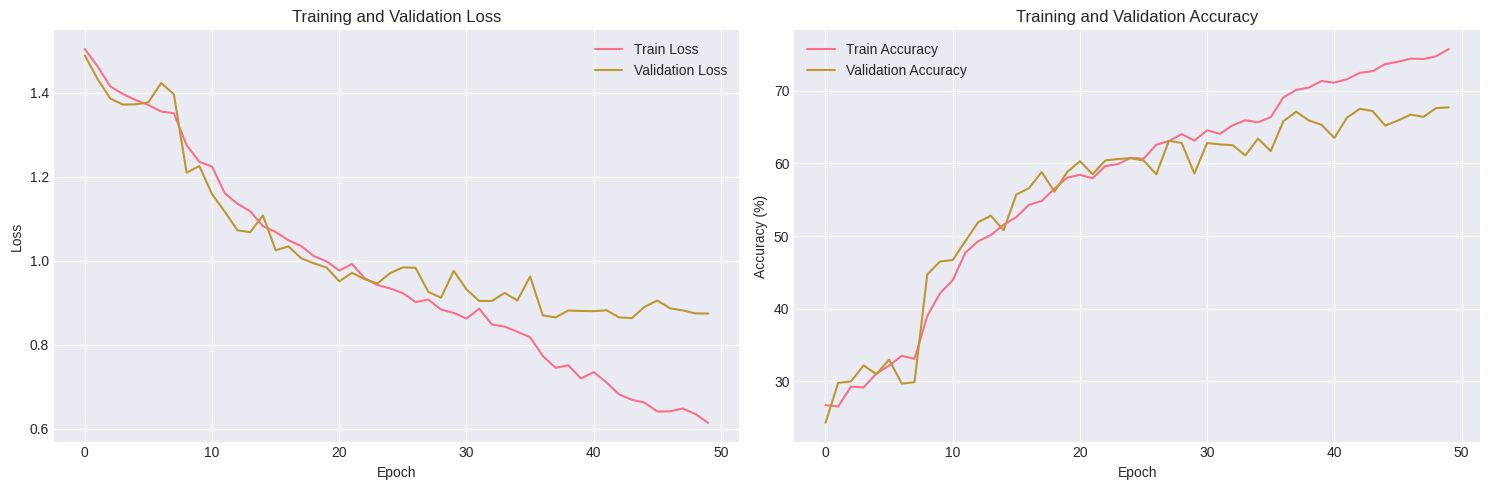

In [12]:
#Model Evaluation Plot
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
    'class_names': class_names
}, 'final_emotion_model.pth')

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Model Performance Analysis

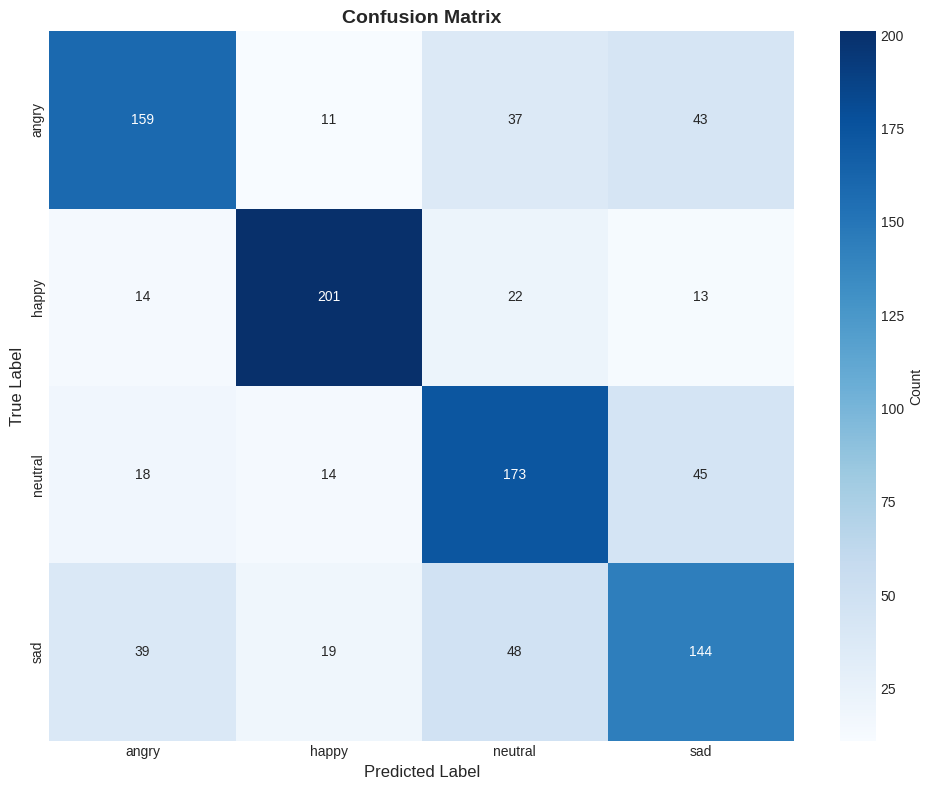


Classification Report:
              precision    recall  f1-score   support

       angry       0.69      0.64      0.66       250
       happy       0.82      0.80      0.81       250
     neutral       0.62      0.69      0.65       250
         sad       0.59      0.58      0.58       250

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.68      0.68      0.68      1000



In [13]:
def analyze_confusion_matrix(model, test_loader, class_names, device):

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return cm

cm = analyze_confusion_matrix(model, test_loader, class_names, device)

# **PART 2B: Prediction**



# **Image Capturing in Colab**

In [14]:
def emotion_analysis(emotions):
    objects = ('angry', 'happy', 'sad', 'neutral')
    y_pos = np.arange(len(objects))

    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

    plt.show()

In [15]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      //Resize the output
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      //Image Capture
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [17]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

Face cropped and saved as capture.jpg
Predicted Emotion: happy
Confidence: 82.62%
All probabilities:
  happy: 82.62%
  neutral: 7.56%
  angry: 5.61%
  sad: 4.20%


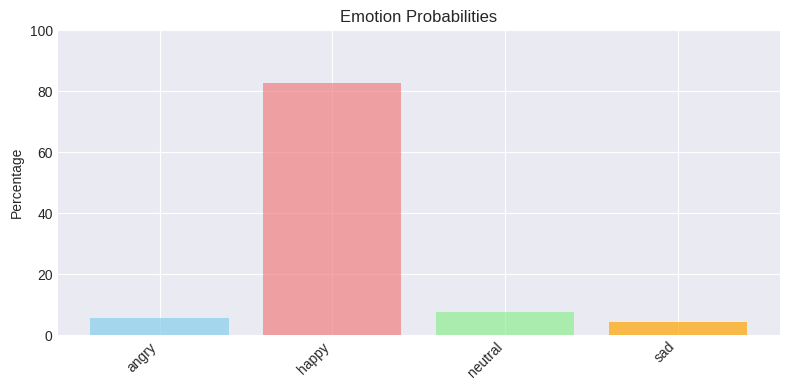

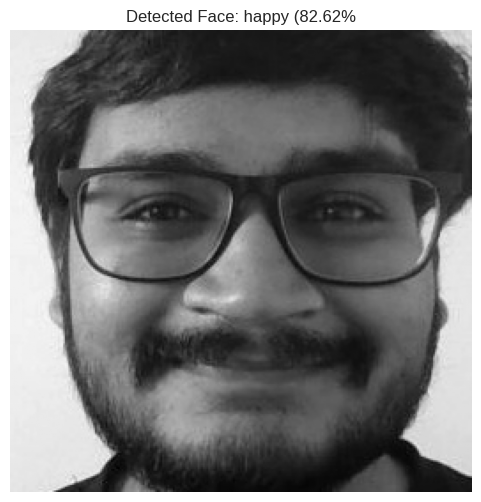

In [18]:
import cv2
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PIL_Image
import torch
from torchvision import transforms
import os

def emotion_analysis(emotions, class_names_for_plot):
    objects = class_names_for_plot
    y_pos = np.arange(len(objects))

    plt.figure(figsize=(8, 4))
    plt.bar(y_pos, emotions, align='center', alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
    plt.xticks(y_pos, objects, rotation=45, ha='right')
    plt.ylabel('Percentage')
    plt.title('Emotion Probabilities')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# Better Facecrop File
def facecrop(image_path):
    facedata = '/content/haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None

    try:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = cascade.detectMultiScale(
            gray_img,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        if len(faces) == 0:
            print(f"No faces found in {image_path}. Please try again.")
            return None

        (x, y, w, h) = sorted(faces, key=lambda f: f[2] * f[3], reverse=True)[0]
        sub_face = img[y:y+h, x:x+w]
        cropped_image_path = 'capture.jpg'
        cv2.imwrite(cropped_image_path, sub_face)
        print(f"Face cropped and saved as {cropped_image_path}")
        return cropped_image_path

    except Exception as e:
        print (f"Error during face cropping: {e}")
        return None

def predict_image(model_instance, image_path, class_names_from_model):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image = PIL_Image.open(image_path)
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model_instance(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    predicted_class = class_names_from_model[predicted.item()]
    confidence_score = confidence.item() * 100

    all_probs = {class_names_from_model[i]: probabilities[0][i].item() * 100 for i in range(len(class_names_from_model))}

    return predicted_class, confidence_score, all_probs


if __name__ == '__main__':
    captured_photo_path = 'photo.jpg'

    cropped_image_path = facecrop(captured_photo_path)

    if cropped_image_path:
        try:
            if 'model' not in globals() or 'class_names' not in globals() or 'device' not in globals():
                raise NameError("Model, class_names, or device not found. Please ensure all previous setup cells are executed.")

            predicted_class, confidence, all_probs = predict_image(model, cropped_image_path, class_names)

            print(f"Predicted Emotion: {predicted_class}")
            print(f"Confidence: {confidence:.2f}%")
            print("All probabilities:")
            for emotion, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True):
                print(f"  {emotion}: {prob:.2f}%")

            emotion_probabilities = [all_probs[cn] for cn in class_names]
            emotion_analysis(emotion_probabilities, class_names)

            plt.figure(figsize=(6, 6))
            true_image = PIL_Image.open(cropped_image_path).convert('L')
            plt.imshow(true_image, cmap='gray')
            plt.title(f"Detected Face: {predicted_class} ({confidence:.2f}%")
            plt.axis('off')
            plt.show()

        except NameError as e:
            print(f"Error: {e}")
        except Exception as e:
            print(f"An unexpected error occurred during prediction: {e}")
    else:
        print("Face cropping failed, cannot proceed with emotion prediction.")